# Note segmentation RNN training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import GRU, Bidirectional, Dropout, Input, TimeDistributed, BatchNormalization, Dense, Conv1D, Activation
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Loading data

In [2]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [3]:
np.mean(data["x"].apply(lambda x: x.shape[0]))

32500.0

Reshaping data

In [4]:
X = np.array([[[]]])
for i in range(data.shape[0]):
    x = data["x"].values[i].reshape((1, 32500, 1))
    X = np.append(X, x)

In [5]:
X = X.reshape(data.shape[0], 32500, 1)

In [6]:
y = np.array([[[]]])
for i in range(data.shape[0]):
    u = data["y"].values[i].reshape((1, 3250, 1))
    y = np.append(y, u)

In [7]:
y = y.reshape(data.shape[0], 3250, 1)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [9]:
X_train.shape, y_train.shape

((107, 32500, 1), (107, 3250, 1))

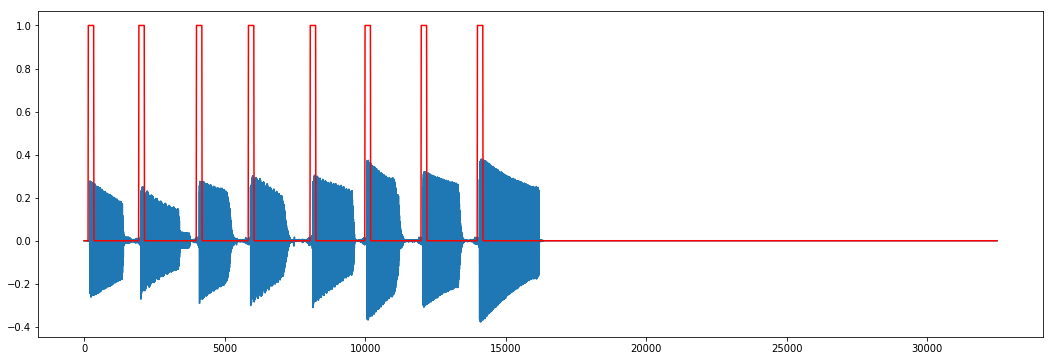

In [39]:
plt.figure(figsize=(18,6))
plt.plot(3*X_train[0])
plt.plot(np.arange(0, 32500, 10), y_train[0], "r")

## Model building

In [14]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=10, strides=10)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Bidirectional(GRU(units = 128, return_sequences = True))(X)
    X = Dropout(0)(X)
    X = BatchNormalization()(X)
    X_output = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [15]:
model = build_model((32500,1))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32500, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3250, 196)         2156      
_________________________________________________________________
batch_normalization_1 (Batch (None, 3250, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 3250, 196)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3250, 256)         249600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3250, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 3250, 256)         1024      
__________

## Model training

In [38]:
model.compile(Adam(), loss="binary_crossentropy", metrics=["accuracy"])

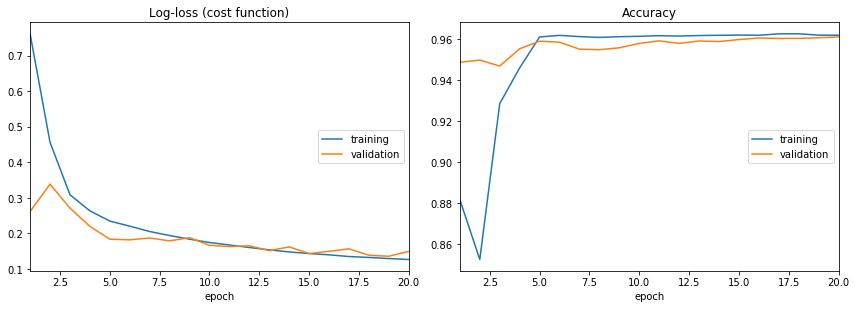

Log-loss (cost function):
training   (min:    0.126, max:    0.762, cur:    0.126)
validation (min:    0.135, max:    0.338, cur:    0.149)

Accuracy:
training   (min:    0.853, max:    0.962, cur:    0.962)
validation (min:    0.947, max:    0.961, cur:    0.961)


In [40]:
model.fit(X_train, y_train, batch_size=32, epochs=20, 
          validation_data=(X_val, y_val), callbacks=[PlotLossesKeras()])

In [65]:
model.save_weights("Checkpoints/seg_gru_v1.hdf5")

## Model testing

In [41]:
pred = model.predict(X_val)

In [42]:
pred.shape

(27, 3250, 1)

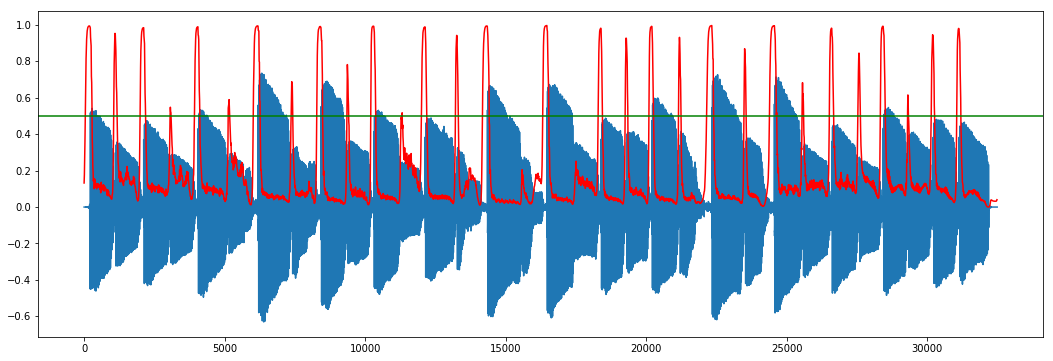

In [64]:
index = 21
plt.figure(figsize=(18,6))
plt.plot(3*X_val[index])
plt.plot(np.arange(0, 32500, 10), pred[index], "r")
plt.axhline(0.5, color="g")